# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [1]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PreprocTools.ji for PreprocTools [top-level]
└ @ Base loading.jl:1190


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [2]:
abrestring="/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [3]:
abrestring

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [4]:
data=abrecacho(abrestring)

Dict{String,Any} with 3 entries:
  "intervalo" => [15700.0, 16700.0]
  "lfp"       => Float32[-4125.0 0.0 … 0.0 0.0; -12.085 24.1699 … 32.2266 10.07…
  "freq"      => 17.8555

In [5]:
lfp=data["lfp"]
intervalo=data["intervalo"]
freq=data["freq"];
data=0

0

Para archivos monstruosamente grandes, o dividimos automaticamente en cachos todo, o escogemos intervalos interesantes y de ahi trabajamos los cachos.

In [6]:
(rengs, cols, nmax)=size(lfp)

(64, 64, 17857)

In [7]:
tiempototalms=round(nmax/freq; digits=1) 
println("Tienes ", nmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 17857 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  1000.1ms.


In [8]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.3753149578188114

In [9]:
exc=lfp[41,34,:];

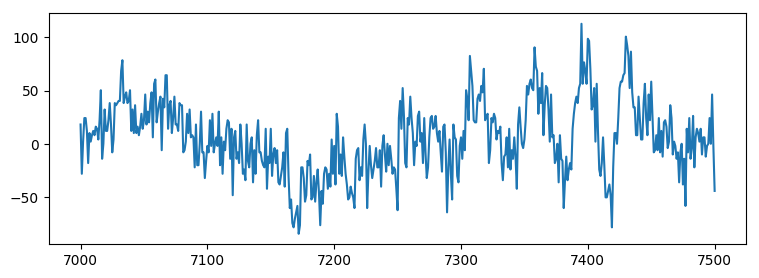

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8f5a9a0e10>

In [10]:
figure(figsize=(9,3))
inter=7000:7500
it=inter./freq
plot(inter, exc[inter])

In [11]:
# De donde a donde quieres recortar
renglonmin=16
renglonmax=50
colmin=32
colmax=64

64

In [12]:
sublfp=lfp[renglonmin:renglonmax, colmin:colmax,:];

In [13]:
round(Sys.free_memory()/Sys.total_memory(),digits=4)

0.3729

In [35]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
inib=1 # inicio busqueda en ms
finb=900 # fin busqueda en ms

conpicos=BuscaCanalRespActPot(lfp, inib, finb, freq,-90,-600,20,35)
saturados=BuscaSaturados(lfp, inib, finb, freq, 801 )
satstd=BuscaSaturadosStd(lfp, inib, finb, freq, 10, 30)
satrd=BuscaRuidosos(lfp, inib, finb, freq, 200, 20)

numerosaturados=length(saturados)
numsatstd=length(satstd)
numsatrd=length(satrd)
numbom=length(conpicos)

println("Encontramos ", numerosaturados, " canales malos por promedio alto.")
println("Encontramos ", numsatstd, " canales malos por mucha desviacion alto.")
println("Encontramos ", numsatrd, " canales malos por ruidi.")
println("Encontramos ", numbom, " canales probablemente con actividad.")


Estoy buscando del cuadro 18 al , 16070
Encontramos 19 canales malos por promedio alto.
Encontramos 78 canales malos por mucha desviacion alto.
Encontramos 65 canales malos por ruidi.
Encontramos 425 canales probablemente con actividad.


In [68]:
malos=union(saturados, satstd, satrd)

Set(Array{Int8,1}[[18, 27], [32, 15], [11, 63], [41, 9], [6, 27], [60, 58], [64, 45], [38, 33], [24, 40], [23, 7]  …  [24, 62], [42, 23], [27, 18], [5, 27], [33, 38], [45, 10], [12, 27], [52, 55], [27, 40], [60, 54], [55, 52]])

In [57]:
function buscasigmaactiva(datos::Array, malos=Set())
    (alto, ancho, largo)=size(datos)
    pur=zeros(alto,ancho)
    for j=1:alto, k=1:ancho
        aux=desviacionventanas(datos[j,k,:], 50, freq)
        pur[j,k]=maximum(aux)
    end
    med=median(pur)
    for q in malos
        reng,col=q[1], q[2]
        pur[reng,col]=med
    end
    return pur
end

buscasigmaactiva (generic function with 2 methods)

In [69]:
mmm=buscasigmaactiva(lfp, malos)

64×64 Array{Float64,2}:
 21.646   21.12    20.0749  21.7297  …  20.3286  22.1761  19.7058  21.2044
 22.948   20.8487  22.622   20.9823     24.5915  21.8366  21.428   20.4005
 19.3582  20.2077  26.6679  22.0558     22.5042  22.1406  20.6325  22.1304
 19.3308  21.1448  19.788   22.4469     23.868   21.5105  43.4524  20.5713
 19.9451  19.8938  23.158   25.2757     23.4494  23.4915  24.4281  23.3233
 21.8613  19.862   27.8886  20.0033  …  19.6947  21.261   22.0816  22.4609
 21.6757  21.059   20.7674  21.0731     22.5308  21.5723  20.7566  21.6335
 20.8788  21.6782  22.1542  20.1716     24.1786  19.9605  21.9194  20.3135
 20.4443  21.7455  23.6597  18.6938     21.1904  21.5665  21.697   22.147 
 21.6458  19.2248  21.6324  21.7126     20.076   21.5093  21.9256  21.2109
 22.2262  22.7337  19.0265  20.8764  …  21.8487  19.8145  21.646   21.4166
 20.282   20.7709  20.2847  21.3908     21.646   20.7771  21.7028  19.8589
 21.5152  21.0364  22.4926  22.569      21.0489  20.9804  21.6043  22.063 
 

In [70]:
mean(mmm), mean(ventastd)

(22.171650435309857, 47.514840585048205)

### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [18]:
(alto, ancho, nmax)=size(lfp)
DesviacionPorCanal=zeros(alto,ancho)
ventastd=zeros(alto,ancho)
proms=zeros(alto, ancho)

for j=1:alto
    for k=1:ancho
        ChorizoExemplo=vec(lfp[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
        aux=desviacionventanas(ChorizoExemplo, 40, freq)
        ventastd[j,k]=maximum(aux)
        proms[j,k]=sum(ChorizoExemplo)
    end
end

In [29]:
function desetaarray(datos::Set)
    x=Int[]
    y=Int[]
    for j in datos
        append!(x, j[2])
        append!(y, j[1])
    end
    return (x, y)
end

desetaarray (generic function with 1 method)

In [30]:
(x,y)=desetaarray(PruebaRespuesta)

([38, 48, 38, 15, 21, 25, 28, 47, 63, 29  …  59, 45, 33, 34, 58, 51, 15, 33, 35, 37], [32, 55, 49, 14, 17, 51, 18, 44, 51, 28  …  31, 18, 23, 48, 52, 37, 41, 30, 50, 4])

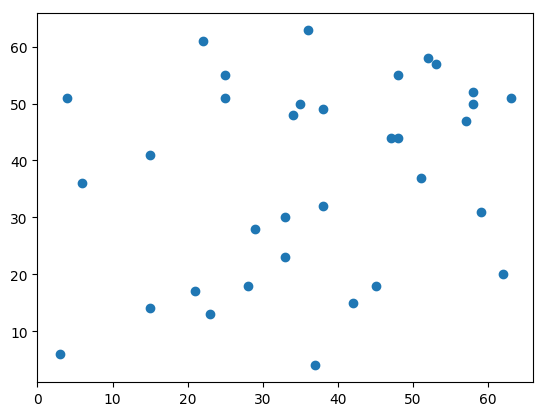

PyObject <matplotlib.collections.PathCollection object at 0x7f8f556b31d0>

In [31]:
scatter(x,y)

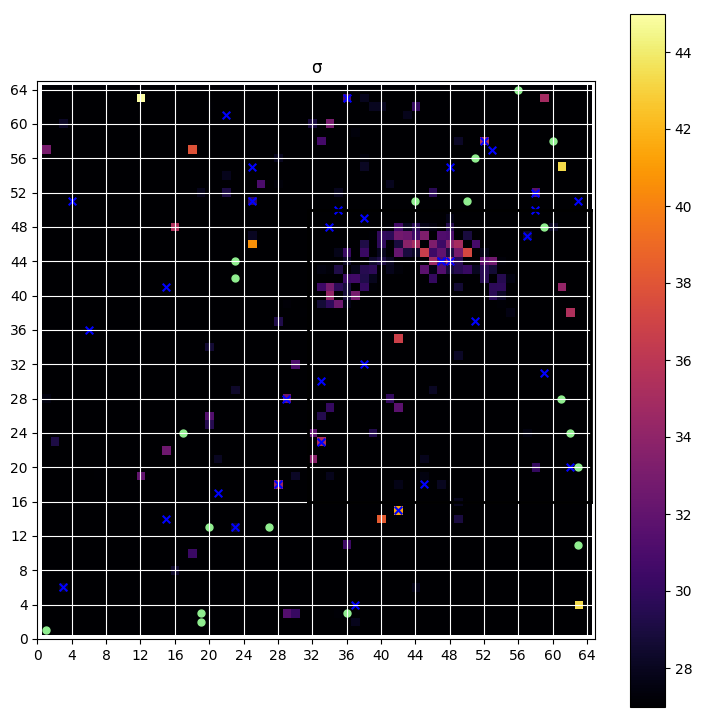

In [71]:
figure(figsize=(9,9))
xlim(0,ancho+1)
ylim(0, alto+1)
title("σ")
limsup=45
liminf=27
imagen=imshow(mmm, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=liminf,vmax=limsup, extent=[0.5,ancho+0.5,0.5,alto+0.5])
cb=colorbar()

(x,y)=desetaarray(PruebaRespuesta)

plot([colmin-0.5, colmin-0.5], [renglonmin,renglonmax], lw=2, c="black")
plot([colmin-0.5, colmax+0.5], [renglonmax,renglonmax], lw=2, c="black")
plot([colmax+0.5, colmax+0.5], [renglonmax,renglonmin], lw=2, c="black")
plot([colmax+0.5, colmin-0.5], [renglonmin,renglonmin], lw=2, c="black")


(x2,y2)=desetaarray(saturados)
(x3,y3)=desetaarray(satstd)
(x4,y4)=desetaarray(satrd)


xticks(0:4:64)
yticks(0:4:64)

scatter(x,y, marker="x",c="blue", s=30)
scatter(x2,y2, marker="o",c="lightgreen", s=25)
#scatter(x3,y3, marker="D",c="green", s=25)
#scatter(x4,y4, marker="x",c="green", s=25)
grid(which="both", color="white")

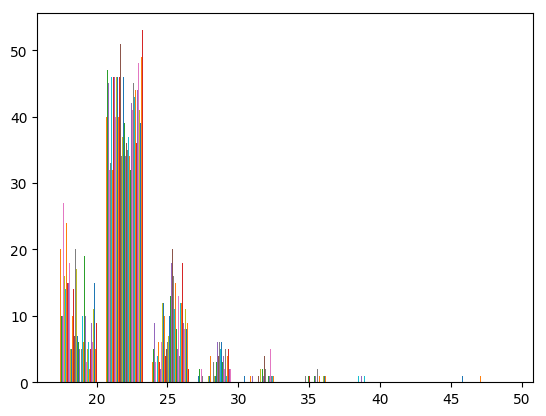

(Array{Float64,1}[[23.0, 35.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [20.0, 40.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [10.0, 47.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [12.0, 45.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [10.0, 45.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [12.0, 48.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [27.0, 32.0, 3.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [30.0, 33.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [16.0, 45.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [14.0, 46.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  …  [9.0, 44.0, 9.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8.0, 45.0, 10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [6.0, 48.0, 8.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [10.0, 44.0, 8.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0], [11.0, 41.0, 11.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [14.0, 42.0, 7.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [15.0, 39.0, 8.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0], [5.0, 49.0, 9.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [5.0, 51.

In [72]:
hist(mmm)

In [73]:
mean(mmm)

22.171650435309857

In [53]:
median(ventastd), std(ventastd)

(21.863051414489746, 208.3956746585053)

In [ ]:
egtrazo=lfp[28,42,:];

In [ ]:
std(egtrazo)

In [44]:
?hist

search: hist hist2D clear_history pushfirst! searchsortedfirst thisind



Plot a histogram.

Compute and draw the histogram of *x*. The return value is a
tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
[*patches0*, *patches1*,...]) if the input contains multiple
data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
    Input values, this takes either a single array or a sequence of
    arrays which are not required to be of the same length.

bins : int or sequence or str, optional
    If an integer is given, ``bins + 1`` bin edges are calculated and
    returned, consistent with `numpy.histogram`.

    If `bins` is a sequence, gives bin edges, including left edge of
    first bin and right edge of last bin.  In this case, `bins` is
    returned unmod

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [ ]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-100,100)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=6
hasta=1200
#intervalo=1:cacho
intervalo=desde:hasta
it=intervalo./freq
grid()
plot(it,egtrazo[intervalo], lw=2)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
indicadorespecifico="_subdatos.h5"
outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPRecortado" => Subdatos,
     "cols" => [colmin, colmax],
      "rengs" => [renglonmin, renglonmax],
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)


In [ ]:
typeof(Subdatos)

In [ ]:
Subdatos=convert.(Float32, Subdatos)